In [77]:
import numpy as np
import json
import os
import pickle
import xrt.backends.raycing.sources as rsources

import params

%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors

matplotlib.use("pgf")

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
        r"\usepackage[T2A]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english,russian]{babel}",
    ]),
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.figsize': [4.75, 4.75 * 9 / 16],
    'figure.dpi': 200
})

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator, LinearLocator, MaxNLocator
from utils.various import datafiles
from utils.xrtutils import get_integral_breadth, bell_fit, get_line_kb

def get_inf_points(xs, ys, expand=[1.3, 1.8]):
    pos_inf_y = np.mean(ys[np.isinf(xs) & (xs > 0)])
    neg_inf_y = np.mean(ys[np.isinf(xs) & (xs < 0)])
    
    pos_inf_x = np.max(xs[~np.isinf(xs)])
    neg_inf_x = np.min(xs[~np.isinf(xs)])
    
    return ([pos_inf_x * expand[0], pos_inf_x * expand[1]], [pos_inf_y, pos_inf_y]), \
        ([neg_inf_x * expand[0], neg_inf_x * expand[1]], [neg_inf_y, neg_inf_y])

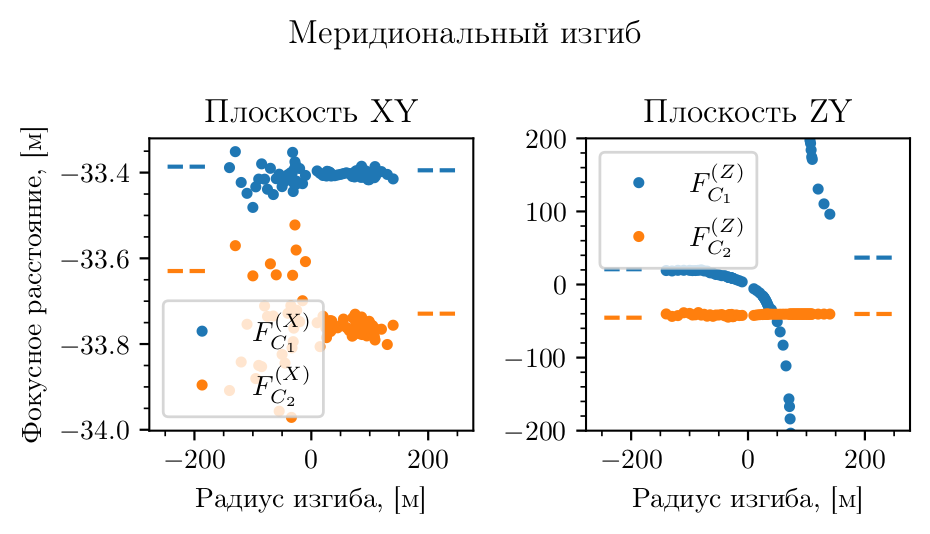

In [80]:
dd = '/Users/glebdovzhenko/Dropbox/PycharmProjects/skif-xrt/datasets/skif15/get_focus'

#################### SKIF 1-5 ####################
##### Superconducting Wiggler at [0, 0, 0]
##### Front End Slit at [0, 15000.0, 0]
##### Si[111] Crystal 1 at [0.0, 33500.0, 0.0]
##### Crystal 1-2 Monitor at [0.0, 33594.21541931476, 12.5]
##### Si[111] Crystal 2 at [0.0, 33688.43083862951, 25.0]
##### Exit Monitor at [0, 114990.0, 25.0]
##### Exit Slit at [0, 115000.0, 25.0]
##### Si[111] Crystal 1 RxRyRz 2.2528497136098933 0.0 0.0
##### Si[111] Crystal 2 RxRyRz 2.120945391887896 0.0 0.0
##################################################


c1c2_cr_dist = np.sqrt(np.sum((np.array([0.0, 33594.21541931476, 12.5]) - np.array([0.0, 33500.0, 0.0]))**2))
em_cr_dist = np.sqrt(np.sum((np.array([0, 114990.0, 25.0]) - np.array([0.0, 33688.43083862951, 25.0]))**2))

r1x, r2x, r1y, r2y, f1x, f2x, f1y, f2y = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    
    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        k, b = get_line_kb(data, show=False)
        fdist = -np.sign(k) * np.sqrt((1. / k) ** 2 + (b / k) ** 2)
        
        if (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XXpr'):
            f1x.append(fdist - c1c2_cr_dist)
            r1x.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'ZZpr'):
            f1y.append(fdist - c1c2_cr_dist)
            r1y.append(metadata['r1'])
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'XXpr'):
            f2x.append(fdist + em_cr_dist)
            r2x.append(metadata['r1'])
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'ZZpr'):
            f2y.append(fdist + em_cr_dist)
            r2y.append(metadata['r1'])
        
r1x, r2x, r1y, r2y, f1x, f2x, f1y, f2y = np.array(r1x), np.array(r2x), np.array(r1y), np.array(r2y), np.array(f1x), np.array(f2x), np.array(f1y), np.array(f2y)
f1x *= 1e-3; f2x *= 1e-3; f1y *= 1e-3; f2y *= 1e-3
f1xp, f1xn = get_inf_points(r1x, f1x)
f2xp, f2xn = get_inf_points(r2x, f2x)
f1yp, f1yn = get_inf_points(r1y, f1y)
f2yp, f2yn = get_inf_points(r2y, f2y)

plt.close(fig)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Меридиональный изгиб')
ax1.plot(r1x, f1x, '.', label='$F_{C_1}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(r2x, f2x, '.', label='$F_{C_2}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.set_xlabel('Радиус изгиба, [м]')
ax1.set_ylabel('Фокусное расстояние, [м]')
ax1.set_title('Плоскость XY')
ax1.legend()
ax2.plot(r1y, f1y, '.', label='$F_{C_1}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(r2y, f2y, '.', label='$F_{C_2}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.set_xlabel('Радиус изгиба, [м]')
#ax2.set_ylabel('Фокусное расстояние, [м]')
ax2.set_title('Плоскость ZY')
ax2.legend()
ax2.set_ylim(-200, 200)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.tight_layout()

fig

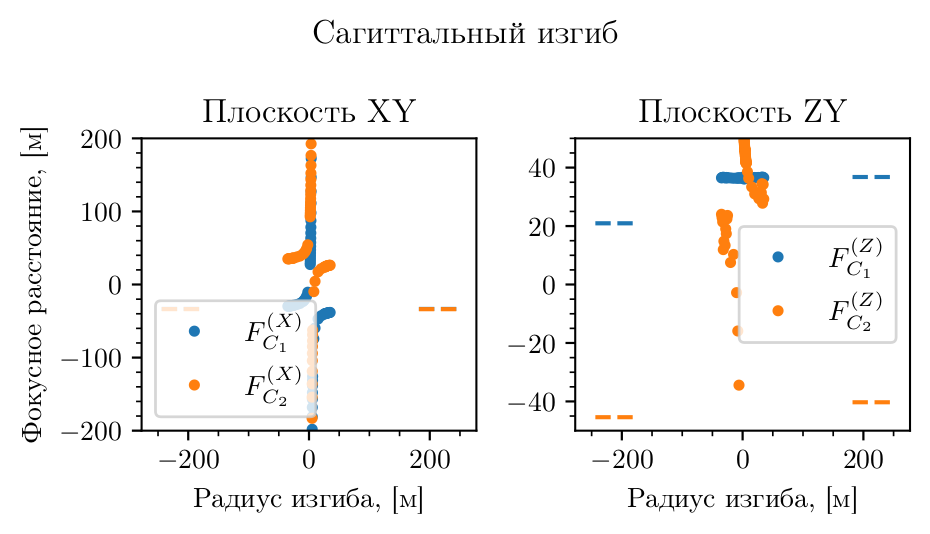

In [82]:
dd = '/Users/glebdovzhenko/Dropbox/PycharmProjects/skif-xrt/datasets/nstu-scw/get_focus'

#################### SKIF 1-5 ####################
##### Superconducting Wiggler at [0, 0, 0]
##### Front End Slit at [0, 15000.0, 0]
##### Si[111] Crystal 1 at [0.0, 33500.0, 0.0]
##### Crystal 1-2 Monitor at [0.0, 33594.21541931476, 12.5]
##### Si[111] Crystal 2 at [0.0, 33688.43083862951, 25.0]
##### Exit Monitor at [0, 114990.0, 25.0]
##### Exit Slit at [0, 115000.0, 25.0]
##### Si[111] Crystal 1 RxRyRz 2.2528497136098933 0.0 0.0
##### Si[111] Crystal 2 RxRyRz 2.120945391887896 0.0 0.0
##################################################


c1c2_cr_dist = np.sqrt(np.sum((np.array([0.0, 33594.21541931476, 12.5]) - np.array([0.0, 33500.0, 0.0]))**2))
em_cr_dist = np.sqrt(np.sum((np.array([0, 114990.0, 25.0]) - np.array([0.0, 33688.43083862951, 25.0]))**2))

r1x, r2x, r1y, r2y, f1x, f2x, f1y, f2y = [], [], [], [], [], [], [], []
for metadata in datafiles(dd):
    
    with open(os.path.join(dd, metadata['file']), 'rb') as f:
        data = pickle.load(f)
        k, b = get_line_kb(data, show=False)
        fdist = -np.sign(k) * np.sqrt((1. / k) ** 2 + (b / k) ** 2)
        
        if (metadata['name'] == 'C1C2') & (metadata['axes'] == 'XXpr'):
            f1x.append(fdist - c1c2_cr_dist)
            r1x.append(metadata['r1'])
        elif (metadata['name'] == 'C1C2') & (metadata['axes'] == 'ZZpr'):
            f1y.append(fdist - c1c2_cr_dist)
            r1y.append(metadata['r1'])
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'XXpr'):
            f2x.append(fdist + em_cr_dist)
            r2x.append(metadata['r1'])
        elif (metadata['name'] == 'EM') & (metadata['axes'] == 'ZZpr'):
            f2y.append(fdist + em_cr_dist)
            r2y.append(metadata['r1'])
        
r1x, r2x, r1y, r2y, f1x, f2x, f1y, f2y = np.array(r1x), np.array(r2x), np.array(r1y), np.array(r2y), np.array(f1x), np.array(f2x), np.array(f1y), np.array(f2y)
f1x *= 1e-3; f2x *= 1e-3; f1y *= 1e-3; f2y *= 1e-3

plt.close(fig)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Сагиттальный изгиб')
ax1.plot(r1x, f1x, '.', label='$F_{C_1}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(*f1xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax1.plot(r2x, f2x, '.', label='$F_{C_2}^{(X)}$', color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.plot(*f2xn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax1.set_xlabel('Радиус изгиба, [м]')
ax1.set_ylabel('Фокусное расстояние, [м]')
ax1.set_title('Плоскость XY')
ax1.legend()
ax2.plot(r1y, f1y, '.', label='$F_{C_1}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(*f1yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:blue'])
ax2.plot(r2y, f2y, '.', label='$F_{C_2}^{(Z)}$', color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yp, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.plot(*f2yn, '--', label=None, color=mcolors.TABLEAU_COLORS['tab:orange'])
ax2.set_xlabel('Радиус изгиба, [м]')
#ax2.set_ylabel('Фокусное расстояние, [м]')
ax2.set_title('Плоскость ZY')
ax2.legend()

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylim(-200, 200)
ax2.set_ylim(-50, 50)

plt.tight_layout()

fig